# Setup iniziale

Vengono installate ed importate le diverse librerie Python necessarie, per poi creare le due liste di immagini necessarie.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install numpy
!pip install torch
!pip install tifffile
!pip install tqdm
!pip install torchvision
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [3]:
import os
import random

import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision.models.vision_transformer import vit_b_16, ViT_B_16_Weights

import tifffile as tiff

from tqdm import tqdm

import matplotlib.pyplot as plt

from torchmetrics.functional import structural_similarity_index_measure as ssim
from torchmetrics.functional import peak_signal_noise_ratio as psnr

In [4]:
sentinel_list = [
    "/content/drive/MyDrive/ColabContent/data/PREDAPPIO/Sentinel/Sentinel2_post_Predappio_2m.tif",
    "/content/drive/MyDrive/ColabContent/data/PREDAPPIO/Sentinel/Sentinel2_pre_Predappio_2m.tif",
    "/content/drive/MyDrive/ColabContent/data/CASOLA_VALSENIO/Sentinel/Sentinel2_post_Casola_2m.tif",
    "/content/drive/MyDrive/ColabContent/data/CASOLA_VALSENIO/Sentinel/Sentinel2_pre_Casola_2m.tif",
    "/content/drive/MyDrive/ColabContent/data/MODIGLIANA/Sentinel/Sentinel2_post_modigliana_2m.tif",
    "/content/drive/MyDrive/ColabContent/data/MODIGLIANA/Sentinel/Sentinel2_pre_Modigliana_2m.tif"
]

aerial_list = [
    "/content/drive/MyDrive/ColabContent/data/PREDAPPIO/Aerial/PREDAPPIO_cgr_2023_2m.tif",
    "/content/drive/MyDrive/ColabContent/data/PREDAPPIO/Aerial/PREDAPPIO_agea_2020_2m.tif",
    "/content/drive/MyDrive/ColabContent/data/CASOLA_VALSENIO/Aerial/CASOLA_VALSENIO_cgr_2023_2m.tif",
    "/content/drive/MyDrive/ColabContent/data/CASOLA_VALSENIO/Aerial/CASOLA_VALSENIO_agea_2020_2m.tif",
    "/content/drive/MyDrive/ColabContent/data/MODIGLIANA/Aerial/MODIGLIANA_cgr_2023_2m.tif",
    "/content/drive/MyDrive/ColabContent/data/MODIGLIANA/Aerial/MODIGLIANA_agea_2020_2m.tif"
]

# Sezione Dataloader

Dichiarazione della classe *PatchGridDataset*, che permette di creare il dataset contenente le diverse coppie Aerial-Sentinel.

Viene inoltre definita la funzione per la creazione effettiva del dataset, con conseguente suddivisione in *Training Set*, *Validation Set* e *Test Set*.

In [5]:
class PatchGridDataset(Dataset):
    def __init__(self, sentinel_paths, aerial_paths, patch_size=128, stride=64, augment=True, normalize=True, max_patches_per_image=1250):
        assert len(sentinel_paths) == len(aerial_paths), "Liste di immagini disallineate."

        self.patch_size = patch_size
        self.stride = stride
        self.augment = augment
        self.normalize = normalize
        self.patches = []  # lista di (sentinel_patch, aerial_patch)

        for s_path, a_path in zip(sentinel_paths, aerial_paths):
            sentinel = tiff.imread(s_path).astype(np.float32)
            aerial = tiff.imread(a_path).astype(np.float32)

            sentinel = self._prepare_image(sentinel)
            aerial = self._prepare_image(aerial)

            # Crop al minimo comune shape
            h = min(sentinel.shape[1], aerial.shape[1])
            w = min(sentinel.shape[2], aerial.shape[2])
            sentinel = sentinel[:, :h, :w]
            aerial = aerial[:, :h, :w]

            # Estrai patch a griglia
            patches = self._extract_patches(sentinel, aerial)
            if max_patches_per_image:
                random.shuffle(patches)
                patches = patches[:max_patches_per_image]
            self.patches.extend(patches)

    def _prepare_image(self, img):
        # Rendi l'immagine sempre con shape [C, H, W]
        if img.ndim == 2:  # immagine grigia
            img = img[np.newaxis, :, :]
        elif img.ndim == 3:
            img = np.transpose(img, (2, 0, 1))  # da HWC a CHW
        return img

    def _extract_patches(self, sentinel, aerial):
        ps = self.patch_size
        st = self.stride
        patches = []
        C, H, W = sentinel.shape

        for y in range(0, H - ps + 1, st):
            for x in range(0, W - ps + 1, st):
                sp = sentinel[:, y:y + ps, x:x + ps]
                ap = aerial[:, y:y + ps, x:x + ps]

                # Scarta patch contenenti valori non finiti
                if not np.isfinite(sp).all() or not np.isfinite(ap).all():
                    continue

                valid_ratio = np.count_nonzero(sp) / sp.size
                if valid_ratio < 0.1:
                    continue

                # Normalizzazione locale per patch
                if self.normalize:
                  sp = (sp - sp.mean()) / (sp.std() + 1e-8)
                  ap = (ap - ap.mean()) / (ap.std() + 1e-8)

                patches.append((sp, ap))

        return patches

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        sentinel, aerial = self.patches[idx]

        if self.augment:
            # Flip verticale
            if random.random() < 0.5:
                sentinel = np.flip(sentinel, axis=1)
                aerial = np.flip(aerial, axis=1)

            # Flip orizzontale
            if random.random() < 0.5:
                sentinel = np.flip(sentinel, axis=2)
                aerial = np.flip(aerial, axis=2)

            # Rotazione 90°
            if random.random() < 0.5:
                sentinel = np.rot90(sentinel, k=1, axes=(1, 2))
                aerial = np.rot90(aerial, k=1, axes=(1, 2))

        # Conversione a tensor PyTorch
        return torch.tensor(sentinel.copy(), dtype=torch.float32), torch.tensor(aerial.copy(), dtype=torch.float32)


def create_dataloaders_image_split(sentinel_paths, aerial_paths, batch_size=32,
                                   val_ratio=0.1, test_ratio=0.1, num_workers=0, **kwargs):
    assert len(sentinel_paths) == len(aerial_paths), "Liste disallineate"
    n_imgs = len(sentinel_paths)

    # Numero minimo di immagini per ciascun set
    assert n_imgs >= 3, "Servono almeno 3 immagini per fare split train/val/test"

    # Split fisso per immagini (non per patch)
    indices = list(range(n_imgs))
    random.seed(42)
    random.shuffle(indices)

    # Assegna 1 immagine al test, 1 alla val, il resto al train
    test_idx = indices[-1:]
    val_idx = indices[-2:-1]
    train_idx = indices[:-2]

    # Costruisci i path per ogni split
    train_s = [sentinel_paths[i] for i in train_idx]
    train_a = [aerial_paths[i] for i in train_idx]

    val_s = [sentinel_paths[i] for i in val_idx]
    val_a = [aerial_paths[i] for i in val_idx]

    test_s = [sentinel_paths[i] for i in test_idx]
    test_a = [aerial_paths[i] for i in test_idx]

    print(f"Train images: {len(train_s)}, Val: {len(val_s)}, Test: {len(test_s)}")

    # Crea dataset
    train_ds = PatchGridDataset(train_s, train_a, **kwargs)
    val_ds = PatchGridDataset(val_s, val_a, **kwargs)
    test_ds = PatchGridDataset(test_s, test_a, **kwargs)

    # Crea DataLoader
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader

# Sezione Trainer

Vengono definite due funzioni:
*   Per effettuare il training di una singola epoca
*   Per fare evaluate, con calcolo dei diversi parametri



In [6]:
def train(model, dataloader, optimizer, criterion, device):
    """
    Esegue un'epoca di training su un dataloader.
    """
    model.train()
    total_loss = 0.0

    for x, y in tqdm(dataloader, desc="Training"):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device, show_images=False):
    """
    Valuta il modello su un dataloader:
    - Loss media
    - SSIM medio
    - PSNR medio
    """
    model.eval()
    total_loss = 0.0
    total_ssim = 0.0
    total_psnr = 0.0
    count = 0

    with torch.no_grad():
        for x, y in tqdm(dataloader, desc="Evaluating"):
            x, y = x.to(device), y.to(device)
            y_pred = model(x)

            loss = criterion(y_pred, y)
            total_loss += loss.item()

            # Clamp per evitare valori fuori range [0, 1]
            y_clamped = torch.clamp(y, 0, 1)
            y_pred_clamped = torch.clamp(y_pred, 0, 1)

            # Calcolo SSIM e PSNR
            batch_ssim = ssim(y_pred_clamped, y_clamped, data_range=1.0)
            batch_psnr = psnr(y_pred_clamped, y_clamped, data_range=1.0)

            total_ssim += batch_ssim.item()
            total_psnr += batch_psnr.item()

            count += 1

            if show_images:
                show_tensor_images(y_pred[0].cpu(), y[0].cpu(), x[0].cpu())
                break

    avg_loss = total_loss / count
    avg_ssim = total_ssim / count
    avg_psnr = total_psnr / count

    print(f"Val Loss: {avg_loss:.4f} | SSIM: {avg_ssim:.4f} | PSNR: {avg_psnr:.2f} dB")

    return avg_loss, avg_ssim, avg_psnr

# Sezione Utils

Vengono definite tre funzioni:
*   Per stampare un possibile output visivo generato dal modello (Foto Aerial, Foto Generata dal modello, Foto Sentinel)
*   Per calcolare l'MSE
*   Per la combined loss (MSE + SSIM)



In [7]:
def show_tensor_images(pred, target, sentinel=None):
    """
    Visualizza il target (immagine aerea reale), il pred (predetta) e opzionalmente l'input Sentinel.
    """
    def to_img(tensor):
        img = tensor.detach().cpu().numpy()
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)
        return img.transpose(1, 2, 0)

    fig, axs = plt.subplots(1, 3 if sentinel is not None else 2, figsize=(15, 5))
    axs[0].imshow(to_img(target))
    axs[0].set_title("Target")
    axs[0].axis("off")

    axs[1].imshow(to_img(pred))
    axs[1].set_title("Predicted")
    axs[1].axis("off")

    if sentinel is not None:
        axs[2].imshow(to_img(sentinel))
        axs[2].set_title("Sentinel (Input)")
        axs[2].axis("off")

    plt.tight_layout()
    plt.show()


def compute_mse(pred, target):
    return torch.mean((pred - target) ** 2).item()

def combined_loss(y_pred, y_true, alpha=0.2):
    """
    Loss combinata: alpha * MSE + (1 - alpha) * (1 - SSIM)
    """
    mse = F.mse_loss(y_pred, y_true)
    ssim_loss = 1 - ssim(torch.clamp(y_pred, 0, 1), torch.clamp(y_true, 0, 1), data_range=1.0)
    return alpha * mse + (1 - alpha) * ssim_loss

# Sezione modello Unet Residuale

In [8]:
class ResidualUNetBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.same_ch = (in_ch == out_ch)

        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
        )
        self.skip = nn.Conv2d(in_ch, out_ch, kernel_size=1) if not self.same_ch else nn.Identity()
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = self.skip(x)
        out = self.conv(x)
        return self.relu(out + residual)


class UNet(nn.Module):
    """
    UNet con blocchi residui e skip esterni additivi (shortcut connections).
    Architettura: Encoder → Bottleneck → Decoder → Output.
    """
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()

        # Encoder
        self.enc1 = ResidualUNetBlock(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = ResidualUNetBlock(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = ResidualUNetBlock(128, 256)

        # Decoder
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = ResidualUNetBlock(256, 128)
        self.skip2 = nn.Conv2d(128, 128, kernel_size=1)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = ResidualUNetBlock(128, 64)
        self.skip1 = nn.Conv2d(64, 64, kernel_size=1)

        # Final output layer
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool2(enc2))

        # Decoder con concatenazione e residual skip esterno
        up2 = self.up2(bottleneck)
        dec2_input = torch.cat([up2, enc2], dim=1)
        dec2_out = self.dec2(dec2_input)
        dec2_out = dec2_out + self.skip2(enc2)

        up1 = self.up1(dec2_out)
        dec1_input = torch.cat([up1, enc1], dim=1)
        dec1_out = self.dec1(dec1_input)
        dec1_out = dec1_out + self.skip1(enc1)

        # Output finale
        return self.final(dec1_out)

# Sezione modello Vit

In [9]:
class ViTRegressor(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, image_size=128, patch_size=8, dim=512, depth=6, heads=8, mlp_dim=1024):
        super().__init__()

        assert image_size % patch_size == 0, "image_size must be divisible by patch_size"
        self.patch_size = patch_size
        self.image_size = image_size
        num_patches = (image_size // patch_size) ** 2
        patch_dim = in_channels * patch_size * patch_size

        # Embedding: usa Conv2d per estrarre i patch embeddings
        self.proj = nn.Conv2d(in_channels, dim, kernel_size=patch_size, stride=patch_size)

        # Positional embeddings
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, dim))

        # Transformer Encoder
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=mlp_dim, batch_first=True),
            num_layers=depth
        )

        # Output projection
        self.output_proj = nn.Linear(dim, patch_dim)

        # Conv finale per proiettare sui canali finali
        self.final_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        B, C, H, W = x.shape

        # Patch embedding
        x = self.proj(x)                # (B, dim, H/P, W/P)
        x = x.flatten(2)                # (B, dim, N)
        x = x.transpose(1, 2)           # (B, N, dim)

        # Positional encoding
        x = x + self.pos_embedding      # (B, N, dim)

        # Transformer
        x = self.transformer(x)         # (B, N, dim)

        # Reconstruct patches
        x = self.output_proj(x)         # (B, N, patch_dim)
        patch_size = self.patch_size
        x = x.view(B, -1, C, patch_size, patch_size)  # (B, N, C, p, p)

        # Ricostruzione immagine
        num_patches_per_side = self.image_size // patch_size
        x = x.view(B, num_patches_per_side, num_patches_per_side, C, patch_size, patch_size)
        x = x.permute(0, 3, 1, 4, 2, 5).contiguous()
        x = x.view(B, C, H, W)

        return self.final_conv(x)

# Sezione preparazione dati, training modelli e plotting risultati

Vengono definite le funzioni per creare i diversi dataset, trainare il modello scelto (tra Unet residuale e Vit) e plottare i risultati finali ottenuti

In [10]:
def prepare_data():
    # Infer number of input channels from Sentinel image
    sample_input = tiff.imread(sentinel_list[0])
    if sample_input.ndim == 2:
        in_channels = 1
    elif sample_input.ndim == 3:
        in_channels = sample_input.shape[2]
    else:
        raise ValueError("Formato immagine Sentinel non supportato")

    # Infer number of output channels from Aerial image
    sample_output = tiff.imread(aerial_list[0])
    if sample_output.ndim == 2:
        out_channels = 1
    elif sample_output.ndim == 3:
        out_channels = sample_output.shape[2]
    else:
        raise ValueError("Formato immagine Aerea non supportato")

    print(f"Inferred input channels: {in_channels}")
    print(f"Inferred output channels: {out_channels}")

    # Create dataloaders
    train_loader, val_loader, test_loader = create_dataloaders_image_split(
        sentinel_list,
        aerial_list,
        batch_size=32,
        patch_size=128,
        stride=64,
        max_patches_per_image=1000
    )

    return train_loader, val_loader, test_loader, in_channels, out_channels

In [11]:
def train_unet(train_loader, val_loader, test_loader, in_channels, out_channels):
    device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
    print("Using device:", device)

    # Inizializzazione del modello UNet
    model_unet = UNet(in_channels=in_channels, out_channels=out_channels).to(device)

    # Loss & Ottimizzatore
    criterion = combined_loss
    optimizer = optim.Adam(model_unet.parameters(), lr=1e-4)

    # Variabili per tracking delle metriche
    train_losses_unet = []
    val_losses_unet = []
    ssim_scores_unet = []
    psnr_scores_unet = []

    # Loop di addestramento
    epochs = 20
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        train_loss = train(model_unet, train_loader, optimizer, criterion, device)
        print(f"Train Loss: {train_loss:.4f}")
        train_losses_unet.append(train_loss)

        val_loss, val_ssim, val_psnr = evaluate(model_unet, val_loader, criterion, device, show_images=False)
        print(f"Validation Loss: {val_loss:.4f} | SSIM: {val_ssim:.4f} | PSNR: {val_psnr:.2f} dB")

        val_losses_unet.append(val_loss)
        ssim_scores_unet.append(val_ssim)
        psnr_scores_unet.append(val_psnr)

        print(f"Sample output after Epoch {epoch + 1}:")
        evaluate(model_unet, val_loader, criterion, device, show_images=True)

    # Final test evaluation
    test_loss_unet, test_ssim_unet, test_psnr_unet = evaluate(model_unet, test_loader, criterion, device, show_images=True)
    print(f"\nTest Loss (MSE): {test_loss_unet:.4f} | SSIM: {test_ssim_unet:.4f} | PSNR: {test_psnr_unet:.2f} dB")

    return train_losses_unet, val_losses_unet, ssim_scores_unet, psnr_scores_unet

In [12]:
def train_vit(train_loader, val_loader, test_loader, in_channels, out_channels):
    device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
    print("Using device:", device)

    # Inizializzazione del modello ViT
    model_vit = ViTRegressor(in_channels=in_channels, out_channels=out_channels, image_size=128).to(device)

    # Loss & Ottimizzatore
    criterion = combined_loss
    optimizer = optim.Adam(model_vit.parameters(), lr=1e-4)

    # Variabili per tracking delle metriche
    train_losses_vit = []
    val_losses_vit = []
    ssim_scores_vit = []
    psnr_scores_vit = []

    # Loop di addestramento
    epochs = 20
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        train_loss = train(model_vit, train_loader, optimizer, criterion, device)
        print(f"Train Loss: {train_loss:.4f}")
        train_losses_vit.append(train_loss)

        val_loss, val_ssim, val_psnr = evaluate(model_vit, val_loader, criterion, device, show_images=False)
        print(f"Validation Loss: {val_loss:.4f} | SSIM: {val_ssim:.4f} | PSNR: {val_psnr:.2f} dB")

        val_losses_vit.append(val_loss)
        ssim_scores_vit.append(val_ssim)
        psnr_scores_vit.append(val_psnr)

        print(f"Sample output after Epoch {epoch + 1}:")
        evaluate(model_vit, val_loader, criterion, device, show_images=True)

    # Final test evaluation
    test_loss_vit, test_ssim_vit, test_psnr_vit = evaluate(model_vit, test_loader, criterion, device, show_images=True)
    print(f"\nTest Loss (MSE): {test_loss_vit:.4f} | SSIM: {test_ssim_vit:.4f} | PSNR: {test_psnr_vit:.2f} dB")

    return train_losses_vit, val_losses_vit, ssim_scores_vit, psnr_scores_vit

In [13]:
def plot_metrics(train_losses, val_losses, ssim_scores, psnr_scores):
    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train MSE', marker='o')
    plt.plot(val_losses, label='Val MSE', marker='x')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('MSE Loss Over Epochs')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(ssim_scores, label='SSIM', marker='s', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('SSIM')
    plt.title('SSIM Over Epochs')
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(psnr_scores, label='PSNR', marker='^', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('PSNR (dB)')
    plt.title('PSNR Over Epochs')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [14]:
def plot_results(train_losses_unet, val_losses_unet, ssim_scores_unet, psnr_scores_unet,
                 train_losses_vit, val_losses_vit, ssim_scores_vit, psnr_scores_vit):
    # Grafico delle losses di training e validazione
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses_unet, label='UNet Train Loss')
    plt.plot(val_losses_unet, label='UNet Validation Loss')
    plt.plot(train_losses_vit, label='ViT Train Loss')
    plt.plot(val_losses_vit, label='ViT Validation Loss')
    plt.title('Train & Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Grafico delle metriche SSIM e PSNR
    plt.subplot(1, 2, 2)
    plt.plot(ssim_scores_unet, label='UNet SSIM')
    plt.plot(psnr_scores_unet, label='UNet PSNR')
    plt.plot(ssim_scores_vit, label='ViT SSIM')
    plt.plot(psnr_scores_vit, label='ViT PSNR')
    plt.title('SSIM & PSNR Scores')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Esecuzione finale

Vengono creati i dataset, con conseguente esecuzione del training del modello scelto e plotting dei risultati finali ottenuti

In [ ]:
train_loader, val_loader, test_loader, in_channels, out_channels = prepare_data()

In [ ]:
# Train UNet
train_losses_unet, val_losses_unet, ssim_scores_unet, psnr_scores_unet = train_unet(train_loader, val_loader, test_loader, in_channels, out_channels)

In [ ]:
#UNet plot
plot_metrics(train_losses_unet, val_losses_unet, ssim_scores_unet, psnr_scores_unet)

In [ ]:
# Train ViT
train_losses_vit, val_losses_vit, ssim_scores_vit, psnr_scores_vit = train_vit(train_loader, val_loader, test_loader, in_channels, out_channels)

In [ ]:
# ViT plot
plot_metrics(train_losses_vit, val_losses_vit, ssim_scores_vit, psnr_scores_vit)

In [ ]:
# Plot Results
plot_results(train_losses_unet, val_losses_unet, ssim_scores_unet, psnr_scores_unet, train_losses_vit, val_losses_vit, ssim_scores_vit, psnr_scores_vit)

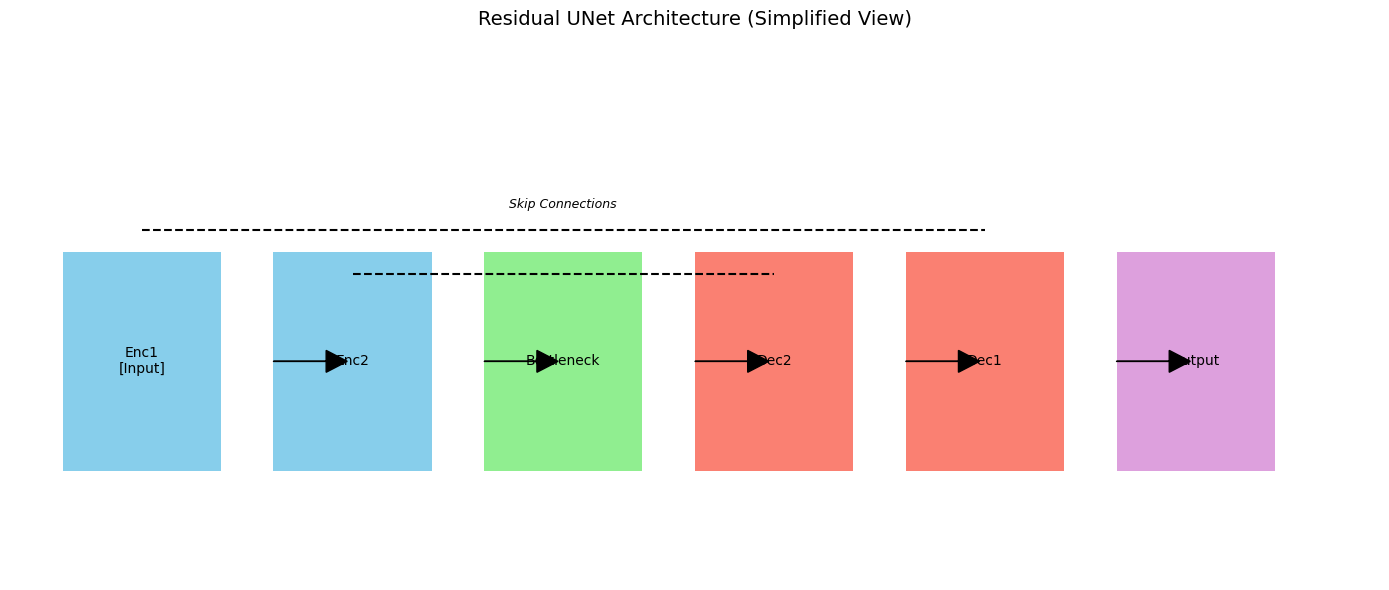

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_unet_diagram():
    fig, ax = plt.subplots(figsize=(14, 6))

    # Encoder blocks
    ax.add_patch(patches.Rectangle((0.5, 2.5), 1.5, 1, facecolor='skyblue'))
    ax.text(1.25, 3, "Enc1\n[Input]", ha='center', va='center')

    ax.add_patch(patches.Rectangle((2.5, 2.5), 1.5, 1, facecolor='skyblue'))
    ax.text(3.25, 3, "Enc2", ha='center', va='center')

    # Bottleneck
    ax.add_patch(patches.Rectangle((4.5, 2.5), 1.5, 1, facecolor='lightgreen'))
    ax.text(5.25, 3, "Bottleneck", ha='center', va='center')

    # Decoder blocks
    ax.add_patch(patches.Rectangle((6.5, 2.5), 1.5, 1, facecolor='salmon'))
    ax.text(7.25, 3, "Dec2", ha='center', va='center')

    ax.add_patch(patches.Rectangle((8.5, 2.5), 1.5, 1, facecolor='salmon'))
    ax.text(9.25, 3, "Dec1", ha='center', va='center')

    # Output
    ax.add_patch(patches.Rectangle((10.5, 2.5), 1.5, 1, facecolor='plum'))
    ax.text(11.25, 3, "Output", ha='center', va='center')

    # Arrows
    for x in [2, 4, 6, 8, 10]:
        ax.arrow(x + 0.5, 3, 0.5, 0, head_width=0.1, head_length=0.2, fc='k', ec='k')

    # Skip connections
    ax.plot([1.25, 9.25], [3.6, 3.6], 'k--')
    ax.plot([3.25, 7.25], [3.4, 3.4], 'k--')
    ax.annotate("Skip Connections", xy=(5.25, 3.7), ha='center', fontsize=9, style='italic')

    ax.set_xlim(0, 13)
    ax.set_ylim(2, 4.5)
    ax.axis('off')
    plt.title("Residual UNet Architecture (Simplified View)", fontsize=14)
    plt.tight_layout()
    plt.show()

draw_unet_diagram()
